In [2]:
import os

import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv(os.path.join('data', 'data.csv'))

In [5]:
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float64')
df['TotalCharges'] = df['TotalCharges'].replace(' ', '0').astype('float64')

In [6]:
df.to_csv(os.path.join('data', 'data.csv'))

In [10]:
pd.read_csv(os.path.join('data', 'data.csv')).drop(columns=['Unnamed: 0']).to_csv(os.path.join('data', 'data.csv'), index=False)

In [23]:
df = pd.read_csv(os.path.join('data', 'data.csv'))

In [24]:
df['SeniorCitizen'] = np.where(df['SeniorCitizen'] == 0,
         'No',
         'Yes'
)

In [25]:
df.to_csv(r'data/data.csv',  index=False)

In [28]:
import re

In [38]:
df.columns = [re.sub(r"(\w)([A-Z])", r"\1_\2", col).upper() for col in df.columns]

In [39]:
df.to_csv(r'data/data.csv',  index=False)

In [41]:
df = pd.read_csv(r'data/data.csv')

In [42]:
df.columns

Index(['CUSTOMER_ID', 'GENDER', 'SENIOR_CITIZEN', 'PARTNER', 'DEPENDENTS',
       'TENURE', 'PHONE_SERVICE', 'MULTIPLE_LINES', 'INTERNET_SERVICE',
       'ONLINE_SECURITY', 'ONLINE_BACKUP', 'DEVICE_PROTECTION', 'TECH_SUPPORT',
       'STREAMING_TV', 'STREAMING_MOVIES', 'CONTRACT', 'PAPERLESS_BILLING',
       'PAYMENT_METHOD', 'MONTHLY_CHARGES', 'TOTAL_CHARGES', 'CHURN'],
      dtype='object')

In [76]:
col =  'MONTHLY_CHARGES'
print('columns: ',col.lower())
print('values: ', list(df[col].value_counts().index))

columns:  monthly_charges
values:  [20.05, 19.85, 19.95, 19.9, 20.0, 19.7, 19.65, 19.55, 20.15, 19.75, 20.25, 20.35, 19.8, 20.1, 19.6, 20.2, 19.5, 20.45, 19.4, 20.4, 19.45, 20.5, 20.3, 20.55, 19.35, 19.3, 20.65, 25.25, 25.1, 19.25, 25.0, 19.2, 84.8, 20.75, 74.4, 81.0, 24.8, 24.45, 20.6, 20.85, 79.2, 70.15, 25.05, 25.15, 79.85, 80.45, 89.85, 75.35, 95.0, 69.95, 20.7, 89.55, 80.85, 24.7, 70.3, 75.5, 94.4, 25.4, 24.95, 19.1, 74.9, 55.0, 80.55, 84.3, 85.45, 85.3, 80.6, 74.35, 60.0, 75.1, 74.3, 24.4, 90.05, 19.15, 80.0, 99.0, 55.3, 45.0, 95.1, 24.9, 74.95, 69.5, 104.4, 50.15, 75.3, 84.6, 25.45, 70.1, 25.2, 25.3, 80.3, 85.35, 24.75, 73.85, 100.55, 25.7, 79.15, 45.3, 69.75, 69.1, 99.5, 50.55, 69.65, 94.1, 74.75, 100.05, 24.25, 20.9, 90.8, 95.65, 78.95, 24.85, 25.6, 69.7, 74.6, 94.0, 79.6, 55.7, 84.5, 54.2, 79.95, 55.8, 54.65, 75.2, 94.65, 90.6, 90.45, 90.1, 19.05, 70.4, 54.75, 59.45, 59.8, 80.5, 89.15, 100.3, 44.45, 49.85, 89.4, 84.05, 84.45, 90.4, 69.35, 70.7, 74.55, 104.05, 99.65, 85.2, 89.

In [94]:
for col in df.select_dtypes(['object']).columns.drop('CUSTOMER_ID'):
    df[col] = df[col].str.lower()
    df[col] = df[col].str.replace('(', '').str.replace(')', '').str.replace(' ', '_').str.replace('-', '_')

In [102]:
df.to_csv(r'data/data.csv', index=False)

# Starting Modelling

In [9]:
import numpy as np
import pandas as pd

import catboost as cat

In [10]:
df = pd.read_csv(r'data/data.csv')

In [11]:
binary_cols = []
for col in df.columns:
    if df[col].nunique() == 2:
        binary_cols.append(col)

In [12]:
df_processed = df.copy()
for col in binary_cols:
    df_processed[col] = np.where(df_processed[col] == 'yes',
                                 1,
                                 0)
    df_processed[col] = df_processed[col].astype('int32')

In [16]:
from sklearn.model_selection import train_test_split

In [15]:
def split_data(df: pd.DataFrame, target: str, test_size: float, 
               val_size: float=None, random_state:int = 0):
    """
    returns (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    if not val_size:
        val_size = test_size / (1 - test_size)

    train_val, test = train_test_split(df, test_size=test_size, stratify=df[target], random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_size, stratify=train_val[target], random_state=random_state)

    X_train = train[train.columns.drop(target)]
    X_val = val[val.columns.drop(target)]
    X_test = test[test.columns.drop(target)]

    y_train = train[target]
    y_val = val[target]
    y_test = test[target]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
df_processed = df_processed.drop(columns='CUSTOMER_ID')

In [17]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_processed, target="CHURN", test_size=0.15)

In [28]:
cat_columns = [
    'MULTIPLE_LINES',
    'INTERNET_SERVICE',
    'ONLINE_SECURITY',
    'ONLINE_BACKUP',
    'DEVICE_PROTECTION',
    'TECH_SUPPORT',
    'STREAMING_TV',
    'STREAMING_MOVIES',
    'CONTRACT',
    'PAYMENT_METHOD'
    ]

model = cat.CatBoostClassifier(early_stopping_rounds=20)

train_pool = cat.Pool(X_train, y_train, cat_features=cat_columns)
val_pool = cat.Pool(X_val, y_val, cat_features=cat_columns)

In [29]:
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.046992
0:	learn: 0.6617325	test: 0.6633679	best: 0.6633679 (0)	total: 30.6ms	remaining: 30.6s
1:	learn: 0.6351004	test: 0.6375061	best: 0.6375061 (1)	total: 67.9ms	remaining: 33.9s
2:	learn: 0.6110570	test: 0.6146053	best: 0.6146053 (2)	total: 106ms	remaining: 35.3s
3:	learn: 0.5900531	test: 0.5947342	best: 0.5947342 (3)	total: 140ms	remaining: 35s
4:	learn: 0.5693635	test: 0.5758554	best: 0.5758554 (4)	total: 175ms	remaining: 34.9s
5:	learn: 0.5525496	test: 0.5606631	best: 0.5606631 (5)	total: 211ms	remaining: 35s
6:	learn: 0.5377178	test: 0.5465215	best: 0.5465215 (6)	total: 247ms	remaining: 35.1s
7:	learn: 0.5269077	test: 0.5358310	best: 0.5358310 (7)	total: 281ms	remaining: 34.9s
8:	learn: 0.5177421	test: 0.5271116	best: 0.5271116 (8)	total: 302ms	remaining: 33.3s
9:	learn: 0.5108432	test: 0.5201894	best: 0.5201894 (9)	total: 321ms	remaining: 31.8s
10:	learn: 0.5006360	test: 0.5111020	best: 0.5111020 (10)	total: 359ms	remaining: 32.2s
11:	learn: 0.4914584	tes

In [32]:
pred_test = model.predict_proba(X_test)[:,-1]

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from scipy.stats import ks_2samp
from operator import itemgetter

In [34]:
def classification_predictive_power(y, pred, scoring_func=lambda x: x):
    """
    makes 4 plots:
    first two plots are PDF and CDF of probabilities or scores (if additional scoring/transformation function is provided)
    the third plot is a confusion matrix and the final plot is a classification report
    the function also calculates KS statistic, AUC and accuracy
    """
    title_font_size = 14
    table_cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=1,as_cmap=True)
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(2,2, figsize=(18,14))

    #PDF
    ks_data = pd.DataFrame({'Target': y, 'prob': pred})
    ks_data['SCORE'] = ks_data['prob'].apply(scoring_func)
    sns.histplot(data=ks_data, x='SCORE', hue='Target',  stat='probability', kde=True, bins=20, common_bins=False, 
                 common_norm=False, palette=['darkorange', 'grey'], ax=ax[0][0], edgecolor='black')
    ax[0][0].set_title('PDF', fontsize=title_font_size)

    #CDF
    sns.kdeplot(data=ks_data,x='SCORE', hue='Target', cumulative=True, common_norm=False, common_grid=True,
                palette=['darkorange', 'grey'], ax=ax[0][1])
    ax[0][1].set_title('CDF', fontsize=title_font_size)

    #confusion matrix
    ConfusionMatrixDisplay.from_predictions(y, pred > 0.5, ax=ax[1][0], cmap=table_cmap)
    ax[1][0].grid(None)
    ax[1][0].set_title('Confusion Matrix', fontsize=title_font_size)

    # classification report
    cr = pd.DataFrame(itemgetter('0','1')(classification_report(y, pred>.5, output_dict=True))).drop(columns = 'support')
    sns.heatmap(cr,annot=True,vmax=1,fmt='.5f',ax=ax[1][1],
                cmap=table_cmap)
    ax[1][1].set_title('Classification Report', fontsize=title_font_size)
    
    # KS, AUC, Accuracy
    fig.suptitle(f"""\
                 KS - {ks_2samp(ks_data.query('Target == 0')['SCORE'], ks_data.query('Target == 1')['SCORE'])[0]:.4f}\
                 AUC - {roc_auc_score(y, pred):.4f}\
                 Accuracy - {accuracy_score(y, pred>.5):.4f}""", y=.95, fontsize=16)
    plt.show()

In [36]:
pred_train = model.predict_proba(X_train)[:,-1]

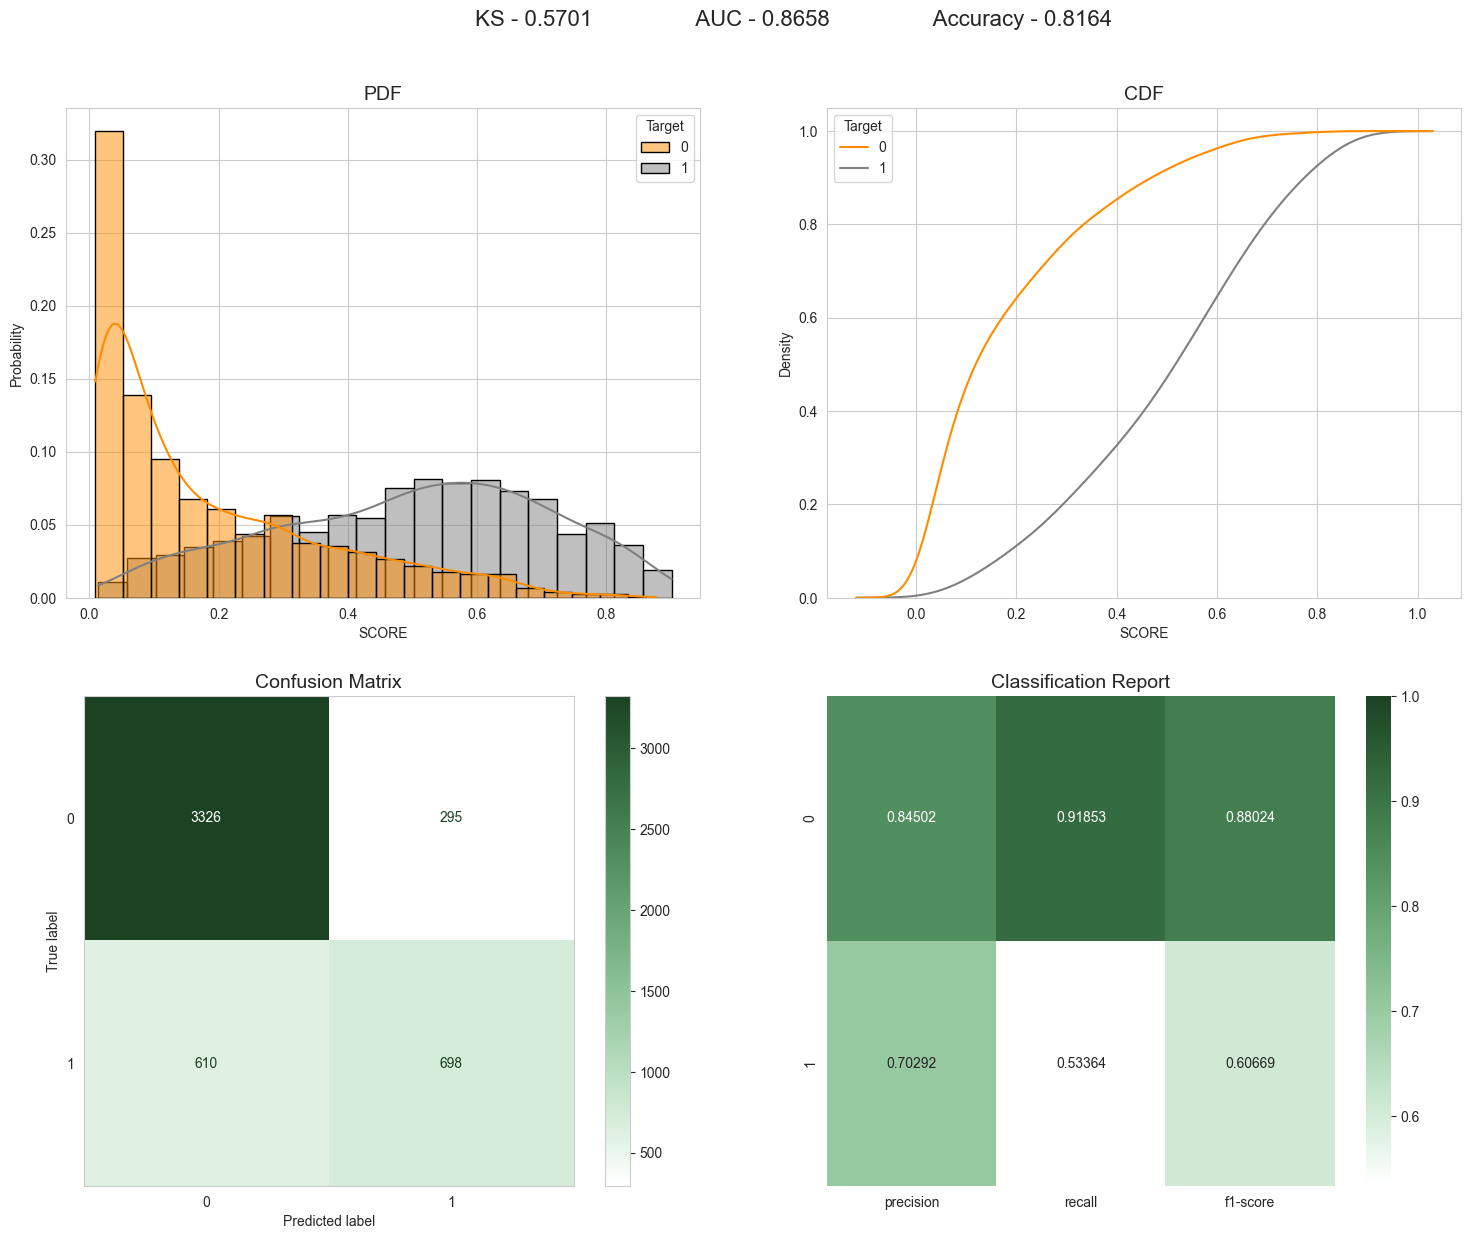

In [37]:
classification_predictive_power(y_train, pred_train)

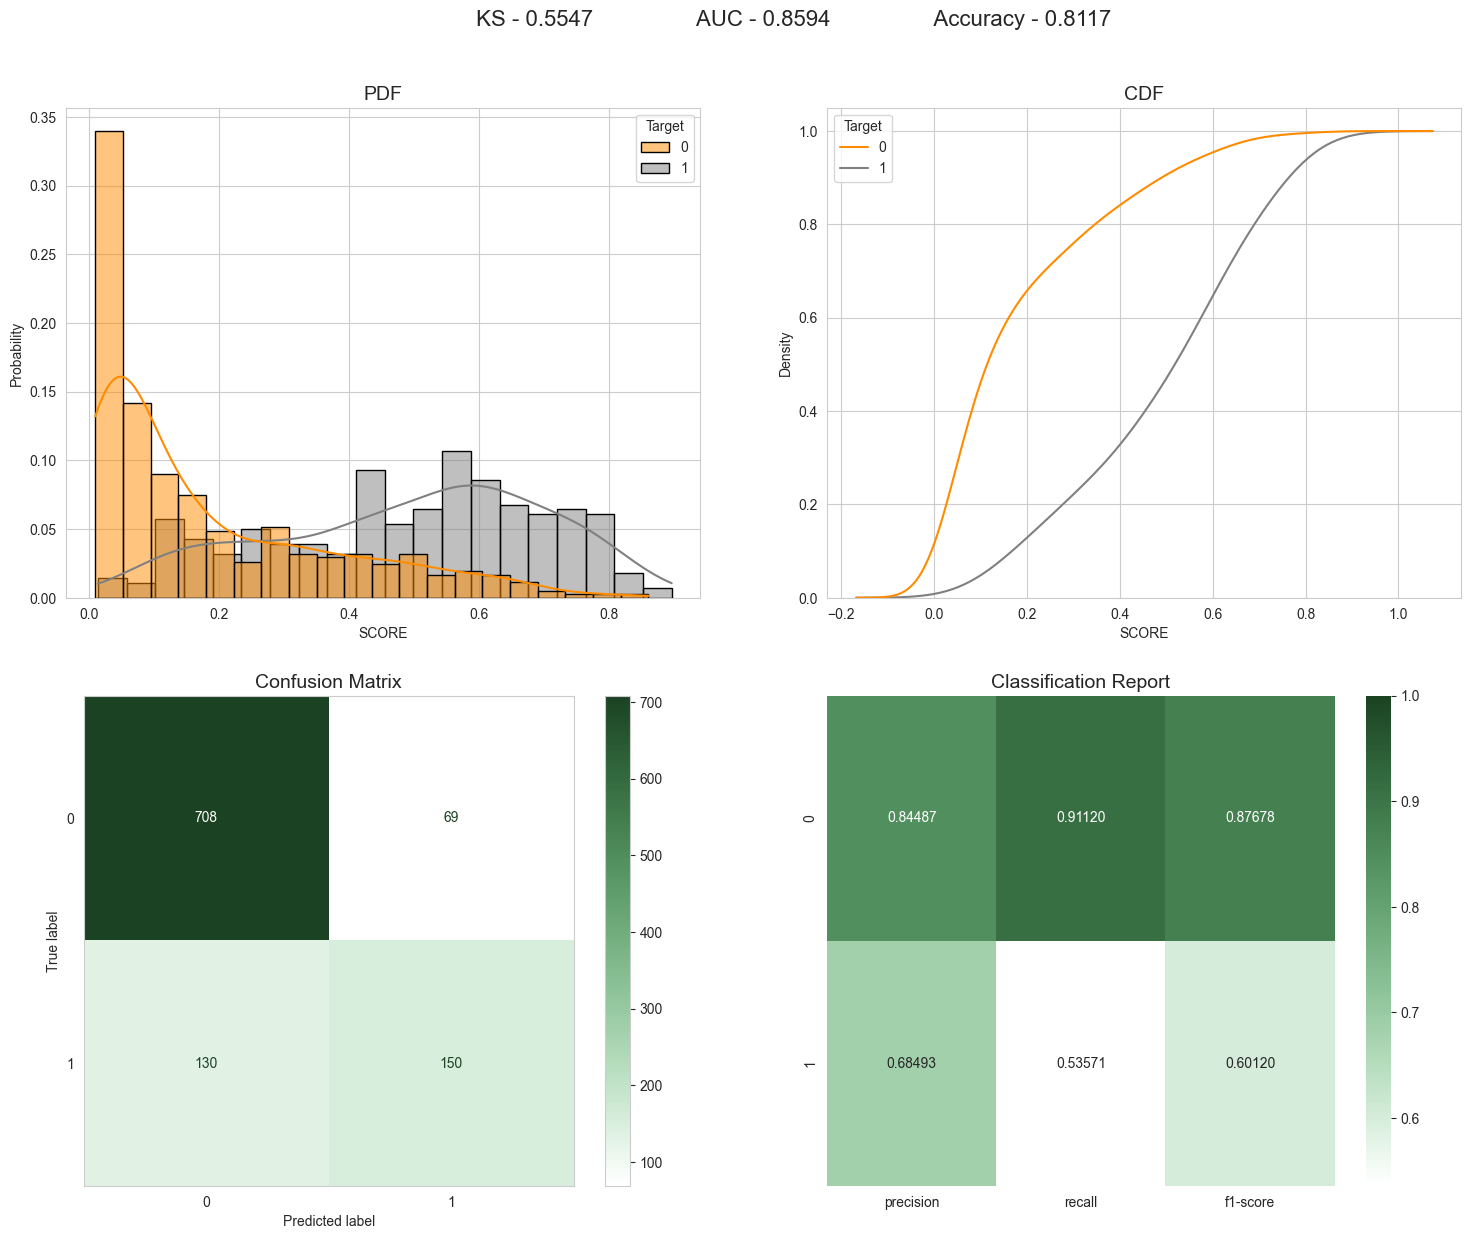

In [35]:
classification_predictive_power(y_test, pred_test)

In [39]:
df_processed

,GENDER,SENIOR_CITIZEN,PARTNER,DEPENDENTS,TENURE,PHONE_SERVICE,MULTIPLE_LINES,INTERNET_SERVICE,ONLINE_SECURITY,ONLINE_BACKUP,DEVICE_PROTECTION,TECH_SUPPORT,STREAMING_TV,STREAMING_MOVIES,CONTRACT,PAPERLESS_BILLING,PAYMENT_METHOD,MONTHLY_CHARGES,TOTAL_CHARGES,CHURN
0,0,0,1,0,1,0,no_phone_service,dsl,no,yes,no,no,no,no,month_to_month,1,electronic_check,29.85,29.85,0
1,0,0,0,0,34,1,no,dsl,yes,no,yes,no,no,no,one_year,0,mailed_check,56.95,1889.50,0
2,0,0,0,0,2,1,no,dsl,yes,yes,no,no,no,no,month_to_month,1,mailed_check,53.85,108.15,1
3,0,0,0,0,45,0,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,0,bank_transfer_automatic,42.30,1840.75,0
4,0,0,0,0,2,1,no,fiber_optic,no,no,no,no,no,no,month_to_month,1,electronic_check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,yes,dsl,yes,no,yes,yes,yes,yes,one_year,1,mailed_check,84.80,1990.50,0
7039,0,0,1,1,72,1,yes,fiber_optic,no,yes,yes,no,yes,yes,one_year,1,credit_card_automatic,103.20,7362.90,0
7040,0,0,1,1,11,0,no_phone_service,dsl,yes,no,no,no,no,no,month_to_month,1,electronic_check,29.60,346.45,0
7041,0,1,1,0,4,1,yes,fiber_optic,no,no,no,no,no,no,month_to_month,1,mailed_check,74.40,306.60,1


In [42]:
import os

In [43]:
model.save_model(os.path.join('models', 'model'))   

In [40]:


model = cat.CatBoostClassifier()      
model.load_model(os.path.join('models', 'model'))

In [46]:
for col in model.feature_names_:
    print(f"'{col.lower()}': request.form['{col.lower()}'],")

'gender': request.form['gender'],
'senior_citizen': request.form['senior_citizen'],
'partner': request.form['partner'],
'dependents': request.form['dependents'],
'tenure': request.form['tenure'],
'phone_service': request.form['phone_service'],
'multiple_lines': request.form['multiple_lines'],
'internet_service': request.form['internet_service'],
'online_security': request.form['online_security'],
'online_backup': request.form['online_backup'],
'device_protection': request.form['device_protection'],
'tech_support': request.form['tech_support'],
'streaming_tv': request.form['streaming_tv'],
'streaming_movies': request.form['streaming_movies'],
'contract': request.form['contract'],
'paperless_billing': request.form['paperless_billing'],
'payment_method': request.form['payment_method'],
'monthly_charges': request.form['monthly_charges'],
'total_charges': request.form['total_charges'],


In [38]:
model.feature_names_

['GENDER',
 'SENIOR_CITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'TENURE',
 'PHONE_SERVICE',
 'MULTIPLE_LINES',
 'INTERNET_SERVICE',
 'ONLINE_SECURITY',
 'ONLINE_BACKUP',
 'DEVICE_PROTECTION',
 'TECH_SUPPORT',
 'STREAMING_TV',
 'STREAMING_MOVIES',
 'CONTRACT',
 'PAPERLESS_BILLING',
 'PAYMENT_METHOD',
 'MONTHLY_CHARGES',
 'TOTAL_CHARGES']